### Data Preparation & Loading

In [18]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

In [19]:
# Set the random seed for reproducibility
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [20]:
# Load the stocks data
df_stocks = pd.read_csv(
    Path("../Files/api_data.csv"),
    index_col="date",
    infer_datetime_format=True,
    parse_dates=True,
)
df_stocks.head()

,open,high,low,close,volume,trade_count,vwap,symbol
date,,,,,,,,
2019-04-22,89.69,90.470,89.58,89.60,970834,9479,90.000447,BUD
2019-04-23,88.56,89.790,88.50,89.25,755451,7907,89.242818,BUD
2019-04-24,89.02,89.130,87.82,88.21,1038366,11509,88.324096,BUD
2019-04-25,86.89,87.020,86.00,86.64,1341678,13124,86.467163,BUD
2019-04-26,87.38,87.625,86.83,87.58,920430,9005,87.292918,BUD


In [21]:
# Isolating the closing data using a pivot table
all_close_prices = df_stocks.pivot(values=["close"], columns= "symbol")
all_close_prices.head()

close                                                        \
symbol        BUD    CGC   CRON     DEO    JAZZ     SAM     SPY     STZ   
date                                                                      
2019-04-22  89.60  48.25  16.86  162.58  125.97  271.34  290.27  205.46   
2019-04-23  89.25  47.41  16.28  163.80  129.78  277.73  292.88  207.48   
2019-04-24  88.21  48.37  16.59  164.13  129.42  276.43  292.23  210.14   
2019-04-25  86.64  48.20  16.52  164.17  128.53  300.00  292.05  212.16   
2019-04-26  87.58  49.91  17.16  166.48  130.99  304.56  293.41  212.16   

                                 
symbol        TAP   TLRY    VFF  
date                             
2019-04-22  61.16  51.82  11.56  
2019-04-23  61.28  50.26  11.08  
2019-04-24  62.51  51.30  12.29  
2019-04-25  62.80  51.27  11.62  
2019-04-26  63.83  53.15  11.57

### Creating input feature vectors "X" and the target vector "y"

In [22]:
#The function will have the following parameters: df_stocks, window, feature_col_number, and target_col_number. 

def window_data(df_stocks, window, feature_col_number, target_col_number):

    X = []
    y = []
    for i in range(len(df_stocks) - window):
        features = df_stocks.iloc[i : (i + window), feature_col_number]
        target = df_stocks.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1,1)

In [23]:
window_size = 2

feature_column = [0,3,5,6,7,8]
target_column = 6
X, y = window_data(all_close_prices["close"], window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[[ 89.6  162.58 271.34 290.27 205.46  61.16]
  [ 89.25 163.8  277.73 292.88 207.48  61.28]]

 [[ 89.25 163.8  277.73 292.88 207.48  61.28]
  [ 88.21 164.13 276.43 292.23 210.14  62.51]]

 [[ 88.21 164.13 276.43 292.23 210.14  62.51]
  [ 86.64 164.17 300.   292.05 212.16  62.8 ]]

 [[ 86.64 164.17 300.   292.05 212.16  62.8 ]
  [ 87.58 166.48 304.56 293.41 212.16  63.83]]

 [[ 87.58 166.48 304.56 293.41 212.16  63.83]
  [ 88.01 166.14 304.09 293.87 212.54  63.88]]] 

y sample values:
[[292.23]
 [292.05]
 [293.41]
 [293.87]
 [294.02]]


### Splitting Data Between Training & Testing Sets 

In [24]:
# Using 90% of the data for training 
split = int(0.9 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

### Scaling the Data with MinMaxScaler

In [25]:
# Scaling the data before training the LSTM model using MinMaxScaler from sklearn to scale all values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Fit scaler to reshaped X_Train
num_instances, num_time_steps, num_features = X_train.shape
X_train_reshaped = np.reshape(X_train, newshape=(-1, num_features))
scaler.fit(X_train_reshaped)
#Scale and reshape X_train to original shape
X_train_scaled = scaler.transform(X_train_reshaped)
X_train_scaled = np.reshape(X_train_scaled, newshape=(num_instances, num_time_steps, num_features))
#Scale and reshape X_test to original shape
num_instances, num_time_steps, num_features = X_test.shape
X_test_reshaped = np.reshape(X_test, newshape=(-1, num_features))
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = np.reshape(X_test_scaled, newshape=(num_instances, num_time_steps, num_features))
#Fit scaler to y_train
scaler.fit(y_train)
#Scale y_train
y_train = scaler.transform(y_train)
#Scale y_test
y_test = scaler.transform(y_test)

### Build & Train the LSTM RNN/Defining the LSTM RNN Model Structure

In [26]:
# Build and Train LSTM RNN in Keeras and fit it using the training data defined above using Keras.
 # Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [27]:
# Define the LSTM RNN model by adding layers
# AND using the dropout layer to prevent overfitting. 
model = Sequential()

number_units = 100
dropout_fraction = 0.03 #Each epoch will randomly drop 20% of units to prevent overfitting.

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 6))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

### Compiling, Summarizing, and Training the Model

In [28]:
# Compiling model using adam optimizer and mean_square_error
model.compile(optimizer="adam", loss="mean_squared_error")

In [29]:
# Summarizing the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 100)            42800     
                                                                 
 dropout_2 (Dropout)         (None, 2, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 2, 100)            80400     
                                                                 
 dropout_3 (Dropout)         (None, 2, 100)            0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [30]:
# Since the model is now defined, it will be fit using 50 epochs. 
# Batch size will be set at 128. 
model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=128, verbose=1, validation_split=.1)

Epoch 1/50
5/5 [==============================] - 31s 1s/step - loss: 0.1781 - val_loss: 0.3575
Epoch 2/50
5/5 [==============================] - 0s 75ms/step - loss: 0.0262 - val_loss: 0.1613
Epoch 3/50
5/5 [==============================] - 0s 79ms/step - loss: 0.0578 - val_loss: 0.2066
Epoch 4/50
5/5 [==============================] - 0s 68ms/step - loss: 0.0453 - val_loss: 0.3408
Epoch 5/50
5/5 [==============================] - 0s 28ms/step - loss: 0.0331 - val_loss: 0.3949
Epoch 6/50
5/5 [==============================] - 0s 33ms/step - loss: 0.0292 - val_loss: 0.3450
Epoch 7/50
5/5 [==============================] - 0s 82ms/step - loss: 0.0263 - val_loss: 0.2815
Epoch 8/50
5/5 [==============================] - 0s 57ms/step - loss: 0.0273 - val_loss: 0.2561
Epoch 9/50
5/5 [==============================] - 0s 68ms/step - loss: 0.0279 - val_loss: 0.2683
Epoch 10/50
5/5 [==============================] - 0s 63ms/step - loss: 0.0271 - val_loss: 0.2796
Epoch 11/50
5/5 [=============

### Model Performance

In [31]:
# Evaluating the model
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 11ms/step - loss: 0.0515


0.0515119843184948

In [32]:
# Make predictions
predicted = model.predict(X_test, batch_size=128)
predicted

1/1 [==============================] - 3s 3s/step


array([[0.7142609 ],
       [0.71134394],
       [0.7024848 ],
       [0.69171286],
       [0.6715573 ],
       [0.6705644 ],
       [0.6894275 ],
       [0.6794971 ],
       [0.6709908 ],
       [0.6767421 ],
       [0.6738226 ],
       [0.6432682 ],
       [0.62591493],
       [0.62328005],
       [0.6124649 ],
       [0.59048796],
       [0.57998633],
       [0.582783  ],
       [0.58792734],
       [0.5969628 ],
       [0.60919976],
       [0.65343493],
       [0.6760532 ],
       [0.6802748 ],
       [0.6622195 ],
       [0.660771  ],
       [0.6707928 ],
       [0.6676036 ],
       [0.67452204],
       [0.67145777],
       [0.6447858 ],
       [0.63202864],
       [0.6751654 ],
       [0.7234359 ],
       [0.71574587],
       [0.70305055],
       [0.69247234],
       [0.67414474],
       [0.6668285 ],
       [0.68032444],
       [0.683882  ],
       [0.7068522 ],
       [0.7174856 ],
       [0.7249839 ],
       [0.71657073],
       [0.71006227],
       [0.6934978 ],
       [0.680

### Plotting Predicted Vs. Real Prices

In [33]:
# Create a DataFrame of Real and Predicted values
df_values = pd.DataFrame({
    "Real": y_test.ravel(),
    "Predicted": predicted.ravel()
    }, index = df_stocks.index[-len(y_test): ])
df_values.head()

,Real,Predicted
date,,
2021-12-31,0.990099,0.714261
2022-01-03,1.000904,0.711344
2022-01-04,1.000275,0.702485
2022-01-05,0.964248,0.691713
2022-01-06,0.962519,0.671557


<AxesSubplot:xlabel='date'>

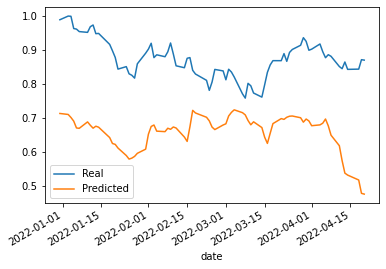

In [34]:
# PLotting real prices vs. predicted
df_values.plot(kind ="line")